In [89]:
# ## Preprocess data
mpcsv=pd.read_csv("FinalTables/MotionPitcure.csv")
mpcsv['originalTitle']=mpcsv['originalTitle'].str.replace(","," ")
mpcsv['crew']=mpcsv['crew'].str.replace(","," ")
mpcsv.to_csv("FinalTables/MotionPitcure.csv", index=False)

/Users/rohinarora/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
crewcsv=pd.read_csv("FinalTables/Crew.csv")
crewcsv['personName']=crewcsv['personName'].str.replace(","," ")
crewcsv.to_csv("FinalTables/Crew.csv",index=False)

In [83]:
Titlecsv=pd.read_csv("FinalTables/Title.csv")
Titlecsv['title']=Titlecsv['title'].str.replace(","," ")
Titlecsv.to_csv("FinalTables/Title.csv",index=False)

/Users/rohinarora/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 2A
<img src="images/2A.png">

### 2B
<img src="images/2B.png">

### 2C
<img src="images/2C.png">

### 2D

> Why to denormalize a database:
1. To enhance query performance
2. To make a database more convenient to manage
3. To facilitate and accelerate reporting

### Test connection

In [15]:
import mysql.connector
import pandas as pd
from mysql.connector import errorcode
def testSql():
    # Connect to server Mysql@localhost:3306
    cnx = mysql.connector.connect(
        host="127.0.0.1",
        port=3306,
        user="root",
        password="12345678")

    # Get a cursor
    cur = cnx.cursor()

    # Execute a query
    cur.execute("SELECT CURDATE()")

    # Fetch one result
    row = cur.fetchone()
    print("Current date is: {0}".format(row[0]))

    # Close connection
    cnx.close()
testSql()

Current date is: 2020-11-16


### Create Tables

In [16]:
# connect to server
cnx = mysql.connector.connect(
    host="127.0.0.1",
    port=3306,
    user="root",
    password="12345678")

# Get a cursor
cursor = cnx.cursor()

In [17]:
# create DB
DB_NAME = 'IMDB'
def create_database(cursor):
    try:
        cursor.execute(
            "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(DB_NAME))
    except mysql.connector.Error as err:
        print("Failed creating database: {}".format(err))
        exit(1)

try:
    cursor.execute("USE {}".format(DB_NAME))
    print ("DB exists")
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(DB_NAME))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cursor)
        print("Database {} created successfully.".format(DB_NAME))
        cnx.database = DB_NAME
    else:
        print(err)
        exit(1)

DB exists


In [18]:
TABLES = {}

#### Create MotionPicture Table

In [102]:
TABLES['MotionPicture'] = (
    """
CREATE TABLE `MotionPicture` (
  `mpId` INT NOT NULL PRIMARY KEY,
  `titleType` VARCHAR(300),
  `primaryTitle` VARCHAR(300),
  `isAdult` Boolean,
  `startYear` INT,
  `endYear` INT,
  `runtimeMinutes` INT,
  `crewList` VARCHAR(400)
)
    """
    )

#create table
table_name='MotionPicture'
table_description = TABLES[table_name]
try:
    print("Creating table {}: ".format(table_name), end='')
    cursor.execute(table_description)
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
        print("already exists.")
    else:
        print(err.msg)
else:
    print("OK")
        
        
#insert data
add_MotionPitcure = ("""INSERT INTO MotionPicture 
(mpId, titleType,primaryTitle,isAdult,startYear,endYear,runtimeMinutes,crewList) 
VALUES (%s, %s,%s, %s,%s, %s,%s,%s)
""")

ignoreMPID=[]
with open("FinalTables/MotionPitcure.csv", 'r') as csv_data:
    for idx,row in enumerate(csv_data):
        if idx==0: continue #skip header
        data=row.strip().split(',')
        crewInfo=data[-1]
        try:
            cursor.execute(add_MotionPitcure,(data[0],data[1],data[2],data[3],data[4],data[5],data[6],crewInfo))
        except mysql.connector.Error as err:
            if "Duplicate entry" in str(err): continue
            if "Out of range value for column 'isAdult' at row" in str(err) or "Data too long for column 'primaryTitle'" in str(err) :
                ignoreMPID.append(data[0])
                continue
            print (err)
            break
cnx.commit()

Creating table MotionPicture: already exists.


In [65]:
# to debug
# mpcsv.head(10)
# cursor.execute("select * from MotionPicture")
# for _ in range(11):
#     print (cursor.fetchone())

In [5]:
ignoreMPID=['10233364','10813978','10970874','11670006','11868642','12149332','12415330','12842848','12866892','12870546','12985206','13006210','13007080','13009172','13053838','13109506','13278010','13354742','13356578','3984412','6271822','6792326','7298012','7395478','7509356','7727908','9822816','9909210']
ignoreMPID=set(ignoreMPID)

In [50]:
cursor.execute("select count(*) from MotionPicture")
cursor.fetchone() #total counts in DB

(7316894,)

#### Episode table

In [11]:
TABLES['Episode'] = (
    """
CREATE TABLE `Episode` (
  `episodeId` INT NOT NULL PRIMARY KEY,
  `seasonNumber` INT,
  `episodeNumber` INT,
  `mpId` INT,
  FOREIGN KEY(mpId) REFERENCES MotionPicture(mpId)
)
    """
    )
table_name='Episode'
table_description = TABLES[table_name]
try:
    print("Creating table {}: ".format(table_name), end='')
    cursor.execute(table_description)
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
        print("already exists.")
    else:
        print(err.msg)
else:
    print("OK")
        
        
add_Episode = ("""INSERT INTO Episode 
(episodeId, seasonNumber,episodeNumber,mpId) 
VALUES (%s, %s,%s,%s)
""")
with open("FinalTables/Episode.csv", 'r') as csv_data:
    for idx,row in enumerate(csv_data):
        if idx==0: continue #skip header
        data=row.strip().split(',')
        if data[3] in ignoreMPID: continue
        try:
            cursor.execute(add_Episode,(data[0],data[1],data[2],data[3]))
        except mysql.connector.Error as err:
            if "Duplicate entry" in str(err): continue
            if  "Cannot add or update a child row: a foreign key constraint fails" in str(err): continue
            print (err)
            break
cnx.commit()


Creating table Episode: already exists.


In [ ]:
# # to debug
# epcsv=pd.read_csv("FinalTables/Episode.csv")
# epcsv.head(10)
# cursor.execute("select * from Episode")
# for _ in range(11):
#     print (cursor.fetchone())
# del epcsv
# del mpcsv

In [49]:
cursor.execute("select count(*) from Episode")
cursor.fetchone() #total counts in DB

(5275338,)

#### Rating Table

In [43]:
TABLES['Rating'] = (
    """
CREATE TABLE `Rating` (
`ratingId` INT NOT NULL PRIMARY KEY,
`averageRating` FLOAT,
`numVotes` INT,
`mpId` INT,
FOREIGN KEY(mpId) REFERENCES MotionPicture(mpId)
)
    """
)

table_name='Rating'
table_description = TABLES[table_name]
try:
    print("Creating table {}: ".format(table_name), end='')
    cursor.execute(table_description)
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
        print("already exists.")
    else:
        print(err.msg)
else:
    print("OK")
    
    
add_rating = ("""INSERT INTO rating 
(ratingId, averageRating,numVotes,mpId) 
VALUES (%s, %s,%s,%s)
""")
with open("FinalTables/Rating.csv", 'r') as csv_data:
    for idx,row in enumerate(csv_data):
        if idx==0: continue
        data=row.strip().split(',')
        if data[3] in ignoreMPID: continue
        try:
            cursor.execute(add_rating,(data[0],data[1],data[2],data[3]))
        except mysql.connector.Error as err:
            if "Duplicate entry" in str(err): continue
            print (err)
cnx.commit()

Creating table Rating: already exists.


In [47]:
cursor.execute("select count(*) from rating")
cursor.fetchone() #total counts in DB

(1088151,)

#### Genre Table

In [46]:
TABLES['genre'] = (
"""
CREATE TABLE `Genre` (
  `genreId` INT NOT NULL PRIMARY KEY,
  `name` VARCHAR(300)
)
""")


table_name='genre'
table_description = TABLES[table_name]
try:
    print("Creating table {}: ".format(table_name), end='')
    cursor.execute(table_description)
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
        print("already exists.")
    else:
        print(err.msg)
else:
    print("OK")#### Table Genre


add_genre = ("""INSERT INTO genre 
(genreId, name) 
VALUES (%s, %s)
""")
with open("FinalTables/Genre.csv", 'r') as csv_data:
    for idx,row in enumerate(csv_data):
        if idx==0: continue #skip header
        data=row.strip().split(',')
        try:
            cursor.execute(add_genre,(data[0],data[1]))
        except mysql.connector.Error as err:
            print (err)
cnx.commit()

Creating table genre: OK


In [48]:
cursor.execute("select count(*) from genre")
cursor.fetchone()  #total counts in DB

(28,)

#### Role Table

In [52]:
TABLES['Role'] = (
"""
CREATE TABLE `Role` (
  `roleId` INT NOT NULL PRIMARY KEY,
  `name` VARCHAR(500)
)
""")

table_name='Role'
table_description = TABLES[table_name]
try:
    print("Creating table {}: ".format(table_name), end='')
    cursor.execute(table_description)
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
        print("already exists.")
    else:
        print(err.msg)
else:
    print("OK")#### Table Genre

    
add_Role = ("""INSERT INTO Role 
(roleId, name) 
VALUES (%s, %s)
""")
with open("FinalTables/Role.csv", 'r') as csv_data:
    for idx,row in enumerate(csv_data):
        if idx==0: continue #skip header
        data=row.strip().split(',')
        try:
            cursor.execute(add_Role,(data[0],data[1]))
        except mysql.connector.Error as err:
            print (err)
cnx.commit()

Creating table Role: already exists.


In [53]:
cursor.execute("select count(*) from Role")
cursor.fetchone() #total counts in DB

(43,)

####  Crew Table

In [63]:
TABLES['Crew'] = (
"""
CREATE TABLE `Crew` (
  `crewId` INT NOT NULL PRIMARY KEY,
  `personName` VARCHAR(500),
  `birthYear` INT,
  `deathYear` INT,
  `status` INT,
  `age` INT,
  `numMovies` INT
)
""")

table_name='Crew'
table_description = TABLES[table_name]
try:
    print("Creating table {}: ".format(table_name), end='')
    cursor.execute(table_description)
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
        print("already exists.")
    else:
        print(err.msg)
else:
    print("OK")#### Table Genre
    

add_Crew = ("""INSERT INTO Crew 
(crewId, personName,birthYear,deathYear,status) 
VALUES (%s, %s,%s,%s,%s)
""")
with open("FinalTables/Crew.csv", 'r') as csv_data:
    for idx,row in enumerate(csv_data):
        if idx==0: continue #skip header
        data=row.strip().split(',')
        try:
            cursor.execute(add_Crew,(data[0],data[1],data[2],data[3],data[4]))
        except mysql.connector.Error as err:
            if "Duplicate entry" in str(err): continue
            print (err)
            break
cnx.commit()

Creating table Crew: already exists.


In [64]:
cursor.execute("select count(*) from Crew")
cursor.fetchone() #total counts in DB

(10486504,)

#### RoleCrew

In [69]:
TABLES['RoleCrew'] = (
"""
CREATE TABLE `RoleCrew` (
  `rcId` INT NOT NULL PRIMARY KEY AUTO_INCREMENT,
  `crewId` INT,
  `roleId` INT,
  FOREIGN KEY(crewId) REFERENCES Crew(crewId),
  FOREIGN KEY(roleId) REFERENCES Role(roleId)
)

""")


table_name='RoleCrew'
table_description = TABLES[table_name]
try:
    print("Creating table {}: ".format(table_name), end='')
    cursor.execute(table_description)
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
        print("already exists.")
    else:
        print(err.msg)
else:
    print("OK")#### Table Genre
    

ignorecrewId=set()
add_RoleCrew = ("""INSERT INTO RoleCrew 
(rcId, crewId,roleId) 
VALUES (%s, %s,%s)
""")
with open("FinalTables/RoleCrew.csv", 'r') as csv_data:
    for idx,row in enumerate(csv_data):
        if idx==0: continue #skip header
        data=row.strip().split(',')
        try:
            cursor.execute(add_RoleCrew,(data[0],data[1],data[2]))
        except mysql.connector.Error as err:
            if "Duplicate entry" in str(err): continue
            if "Cannot add or update a child row: a foreign key constraint fails (`imdb`.`rolecrew`, CONSTRAINT `rolecrew_ibfk_1` FOREIGN KEY (`crewId`) REFERENCES `crew` (`crewId`))" in str(err): 
                ignorecrewId.add(data[1])
                continue
            print (err)
            break
cnx.commit()

Creating table RoleCrew: already exists.


In [70]:
cursor.execute("select count(*) from RoleCrew")
cursor.fetchone() #total counts in DB

(41775514,)

#### MotionPictureCrew

In [88]:
TABLES['MotionPictureCrew'] = (
"""
CREATE TABLE `MotionPictureCrew` (
  `mpcId` INT NOT NULL PRIMARY KEY AUTO_INCREMENT,
  `mpId` INT,
  `crewId` INT,
  FOREIGN KEY(crewId) REFERENCES Crew(crewId),
  FOREIGN KEY(mpId) REFERENCES MotionPicture(mpId)
)
""")


table_name='MotionPictureCrew'
table_description = TABLES[table_name]
try:
    print("Creating table {}: ".format(table_name), end='')
    cursor.execute(table_description)
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
        print("already exists.")
    else:
        print(err.msg)
else:
    print("OK")#### Table Genre
    

ignorempcrewId=set()
ignorempcrewId2=set()
add_MotionPictureCrew = ("""INSERT INTO MotionPictureCrew 
(mpcId, mpId,crewId) 
VALUES (%s, %s,%s)
""")

with open("FinalTables/MotionPitcureCrew.csv", 'r') as csv_data:
    for idx,row in enumerate(csv_data):
        if idx==0: continue #skip header
        data=row.strip().split(',')
        if data[1] in ignoreMPID: continue
        try:
            cursor.execute(add_MotionPictureCrew,(data[0],data[1],data[2]))
        except mysql.connector.Error as err:
            if "Duplicate entry" in str(err): continue
            if "Cannot add or update a child row: a foreign key constraint fails (`imdb`.`motionpicturecrew`, CONSTRAINT `motionpicturecrew_ibfk_1` FOREIGN KEY (`crewId`) REFERENCES `crew` (`crewId`))" in str(err): 
                ignorempcrewId.add(data[2])
                continue
            if "Cannot add or update a child row: a foreign key constraint fails (`imdb`.`motionpicturecrew`, CONSTRAINT `motionpicturecrew_ibfk_2` FOREIGN KEY (`mpId`) REFERENCES `motionpicture` (`mpId`))" in str(err): 
                ignorempcrewId2.add(data[2])
                continue
            print (err)
            break
cnx.commit()


Creating table MotionPictureCrew: already exists.
1206 (HY000): The total number of locks exceeds the lock table size


In [91]:
cursor.execute("select count(*) from MotionPictureCrew")
cursor.fetchone() #total counts in DB

(390967,)

#### Title

In [95]:
TABLES['Title'] = (
"""
CREATE TABLE `Title` (
  `titleId` INT NOT NULL PRIMARY KEY,
  `name` VARCHAR(500),
  `region` VARCHAR(20),
  `language` VARCHAR(20),
  `isOriginalTitle` Boolean,
  `mpId` INT,
  FOREIGN KEY(mpId) REFERENCES MotionPicture(mpId)
)
""")


table_name='Title'
table_description = TABLES[table_name]
try:
    print("Creating table {}: ".format(table_name), end='')
    cursor.execute(table_description)
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
        print("already exists.")
    else:
        print(err.msg)
else:
    print("OK")#### Table Genre



add_Title = ("""INSERT INTO Title 
(titleId, name,region,language,isOriginalTitle,mpId) 
VALUES (%s, %s,%s, %s,%s, %s)
""")
run=10
with open("FinalTables/Title.csv", 'r') as csv_data:
    for idx,row in enumerate(csv_data):
        if idx==0: continue #skip header
        data=row.strip().split(',')
        if data[5] in ignoreMPID: continue
        try:
            cursor.execute(add_Title,(data[0],data[1],data[2],data[3],data[4],data[5]))
        except mysql.connector.Error as err:
            if "Duplicate entry" in str(err): continue
            if "Incorrect integer value: '\\N' for column 'isOriginalTitle' at row 1" in str(err): continue
            print (err)
            break
        run-=1
        if run==0: break
cnx.commit()

Creating table Title: already exists.


In [96]:
cursor.execute("select count(*) from Title")
cursor.fetchone() #total counts in DB

(141172,)

#### MotionPictureGenre

In [99]:
TABLES['MotionPictureGenre'] = (
"""
CREATE TABLE `MotionPictureGenre` (
  `mpgId` INT NOT NULL PRIMARY KEY AUTO_INCREMENT,
  `mpId` INT,
  `genreId` INT,
  FOREIGN KEY(genreId) REFERENCES genre(genreId),
  FOREIGN KEY(mpId) REFERENCES MotionPicture(mpId)
)
""")


table_name='MotionPictureGenre'
table_description = TABLES[table_name]
try:
    print("Creating table {}: ".format(table_name), end='')
    cursor.execute(table_description)
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
        print("already exists.")
    else:
        print(err.msg)
else:
    print("OK")#### Table Genre
    
    
add_MotionPictureGenre = ("""INSERT INTO MotionPictureGenre 
(mpgId, mpId,genreId) 
VALUES (%s, %s,%s)
""")
run=10000
with open("FinalTables/MotionPitcureGenre.csv", 'r') as csv_data:
    for idx,row in enumerate(csv_data):
        if idx==0: continue #skip header
        data=row.strip().split(',')
        if data[1] in ignoreMPID: continue
        try:
            cursor.execute(add_MotionPictureGenre,(data[0],data[1],data[2]))
        except mysql.connector.Error as err:
            if "Duplicate entry" in str(err): continue
            if "Cannot add or update a child row: a foreign key constraint fails (`imdb`.`motionpicturegenre`, CONSTRAINT `motionpicturegenre_ibfk_1` FOREIGN KEY (`genreId`) REFERENCES `genre` (`genreId`))" in str(err): continue
            print (err)
            break
        run-=1
        if run==0: break
cnx.commit()

Creating table MotionPictureGenre: already exists.


In [100]:
cursor.execute("select count(*) from MotionPictureGenre")
cursor.fetchone() #total counts in DB

(10872,)

### 5 UPDATE statements

#### Crew table update for age and number of movies

In [101]:
#query=("""DESCRIBE Crew""")
query=("""SHOW COLUMNS FROM Crew""")
cursor.execute(query)
cursor.fetchall()

[('crewId', b'int', 'NO', 'PRI', None, ''),
 ('personName', b'varchar(500)', 'YES', '', None, ''),
 ('birthYear', b'int', 'YES', '', None, ''),
 ('deathYear', b'int', 'YES', '', None, ''),
 ('status', b'int', 'YES', '', None, ''),
 ('age', b'int', 'YES', '', None, ''),
 ('numMovies', b'int', 'YES', '', None, '')]

#### Crew Table before update

In [105]:
query=('''SELECT * from Crew LIMIT 10''')
cursor.execute(query)
cursor.fetchall()

[(1, 'Fred Astaire', 1899, 1987, 0, 0, None),
 (2, 'Lauren Bacall', 1924, 2014, 0, 0, None),
 (3, 'Brigitte Bardot', 1934, 0, 1, 0, None),
 (4, 'John Belushi', 1949, 1982, 0, 0, None),
 (5, 'Ingmar Bergman', 1918, 2007, 0, 0, None),
 (6, 'Ingrid Bergman', 1915, 1982, 0, 0, None),
 (7, 'Humphrey Bogart', 1899, 1957, 0, 0, None),
 (8, 'Marlon Brando', 1924, 2004, 0, 0, None),
 (9, 'Richard Burton', 1925, 1984, 0, 0, None),
 (10, 'James Cagney', 1899, 1986, 0, 0, None)]

In [106]:
query=('''UPDATE Crew SET age = deathYear - birthYear
where deathYear != 0''')
cursor.execute(query)

In [107]:
query=('''UPDATE crew SET age = 2020 - birthYear
where deathYear = 0;''')
cursor.execute(query)

#### Crew Table after update

In [108]:
query=('''SELECT * from Crew LIMIT 10''')
cursor.execute(query)
cursor.fetchall()

[(1, 'Fred Astaire', 1899, 1987, 0, 88, None),
 (2, 'Lauren Bacall', 1924, 2014, 0, 90, None),
 (3, 'Brigitte Bardot', 1934, 0, 1, 86, None),
 (4, 'John Belushi', 1949, 1982, 0, 33, None),
 (5, 'Ingmar Bergman', 1918, 2007, 0, 89, None),
 (6, 'Ingrid Bergman', 1915, 1982, 0, 67, None),
 (7, 'Humphrey Bogart', 1899, 1957, 0, 58, None),
 (8, 'Marlon Brando', 1924, 2004, 0, 80, None),
 (9, 'Richard Burton', 1925, 1984, 0, 59, None),
 (10, 'James Cagney', 1899, 1986, 0, 87, None)]

#### Update numMovies in Crew table

In [ ]:
query=('''UPDATE CREW C
Set numMovies = (select count(*) from motionpicturecrew mpc group by mpc.crewId
                having mpc.crewId = C.crewId);''')
cursor.execute(query)

### Triggers

Triggers below set the age and number of movies for new update on CREW table

In [54]:
query=('''
CREATE TRIGGER `update_age_insert` 
BEFORE INSERT
ON CREW FOR EACH ROW
BEGIN
IF NEW.deathYear != 0 THEN
SET NEW.age = new.deathYear - new.birthYear;
ELSEIF NEW.deathYear = 0 THEN
SET NEW.age = 2020 - new.birthYear;
END IF;
END;
''')
cursor.execute(query)

In [55]:
query=('''CREATE TRIGGER `update_numovies_insert` 
AFTER INSERT
ON motionpicturecrew FOR EACH ROW
BEGIN
UPDATE CREW C
Set numMovies = (select count(*) from motionpicturecrew mpc group by mpc.crewId having mpc.crewId = C.crewId);
END;
''')
cursor.execute(query)

#### 7. View

In [63]:
query=('''CREATE VIEW ACTOR_INFO2 AS
SELECT personName,name as role, age, case when birthYear = 0 then 'False' else 'True' end as active_status, count(*) as top_movies from Crew c
inner join RoleCrew rc on rc.rcId = c.crewId
inner join Role r on r.roleId = rc.rcId
inner join MotionPictureCrew mpc on mpc.mpcId = c.crewId
inner join MotionPicture mp on mp.mpId = mpc.mpcId
inner join rating rt on rt.mpId = mp.mpId
where rt.averageRating > 3
group by c.crewId
having r.name = 'actress';''')
cursor.execute(query)

In [64]:
query=('''SELECT * from ACTOR_INFO1 LIMIT 10''')
cursor.execute(query)

In [65]:
cursor.fetchone()

In [ ]:
query=('''SELECT * from motionpicture''')
cursor.execute(query)
cursor.fetchone()

#### 8. query that finds the number of seasons for each TV series.

In [19]:
query=('''
select primaryTitle, MAX(seasonNumber) from motionpicture mp
inner join episode e on e.mpId = mp.mpId
group by e.mpId;''')
cursor.execute(query)


In [20]:
result=list(cursor)

In [30]:
from collections import defaultdict,OrderedDict

In [26]:
map1=defaultdict(int)

In [27]:
for a,b in result:
    map1[b]+=1

In [31]:
od = OrderedDict(sorted(map1.items()))

In [36]:
import numpy as np
import matplotlib.pyplot as plt

<BarContainer object of 20 artists>

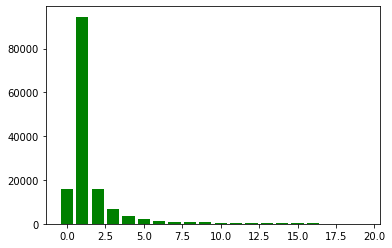

In [53]:
plt.bar(list(od.keys())[:20], list(od.values())[:20], color='g')

#### 9. addActor() 

In [ ]:
# crew_attribs: (crewId, personName, birthYear, deathYear, status)
def addActor(mpId, crewAttribs, roleId = 1):

    query4crew = """INSERT into Crew (crewId, personName, birthYear, deathYear, status) values (%s, %s, %s, %s, %s)"""

    query4mpc = """INSERT into MotionPictureCrew (mpId, crewId) values (%s, %s);"""

    query4rc = """INSERT into RoleCrew (roleId, crewId) values (%s, %s)"""

    cursor.execute(query4crew, crewAttribs)
    cnx.commit()
    cursor.execute(query4mpc, (mpId, crewAttribs[0]))
    cnx.commit()

#### 11

In [69]:
query=('''SELECT personName,name as role, age, count(*) as top_movies from Crew c
inner join RoleCrew rc on rc.rcId = c.crewId
inner join Role r on r.roleId = rc.rcId
inner join MotionPictureCrew mpc on mpc.mpcId = c.crewId
inner join MotionPicture mp on mp.mpId = mpc.mpcId
inner join rating rt on rt.mpId = mp.mpId
where rt.averageRating > (select avg(averageRating) from rating) and c.numMovies > 2
group by c.crewId
having r.name = 'actress' or r.name = 'actor';''')
cursor.execute(query)

In [70]:
cursor.fetchone()

#### 12. Indexing

In [4]:
import time

In [5]:
start=time.time()
query=('''select * from crew c where c.personName = 'Fred Astaire';''')
cursor.execute(query)
cursor.fetchone()
end=time.time()
timeWOIndex=end-start
print ("Time taken without index :",timeWOIndex)

Time taken without index : 3.397634983062744


In [7]:
query=('''CREATE INDEX idx_crew_name ON crew (personName);;''')
cursor.execute(query)

In [8]:
start=time.time()
query=('''select * from crew c where c.personName = 'Fred Astaire';''')
cursor.execute(query)
cursor.fetchone()
end=time.time()
timeWITHIndex=end-start
print ("Time taken with index :",timeWITHIndex)

Time taken with index : 0.004143238067626953


In [ ]:






SELECT personName,name as role, age, status, count(*) as top_movies from Crew c
inner join RoleCrew rc on rc.rcId = c.crewId
inner join Role r on r.roleId = rc.rcId
inner join MotionPictureCrew mpc on mpc.mpcId = c.crewId
inner join MotionPicture mp on mp.mpId = mpc.mpcId
inner join rating rt on rt.mpId = mp.mpId
where averageRating > (select avg(averageRating) from rating) and c.nuMovies > 2
group by c.crewId
having r.name = 'actress' or r.name = 'actor';

-- select * from rating
-- where averageRating > (select avg(averageRating) from rating);
